# 분류 순위 평가
- 점수가 아니라 분류 확률을 이용하는 경우
- 분류 랭킹 평가에는 점수 또는 확률을 사용한다
 - decision_function() 지원: 선형 모델, SVM
 - predict_proba() 지원: 로지스티 회귀, 트리 계열

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [19]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## 데이터 다운로드

In [2]:
data = pd.read_csv("https://github.com/data-labs/data/raw/main/weight-height.csv")

# 성별 인코딩 (남:0, 여:1)
data.Gender = data.Gender.map({'Male':0, 'Female':1})
# 단위 변환 (인치, 파운드 --> cm, kg)
data.Height = data.Height*2.54 # cm
data.Weight = data.Weight*0.453592 # kg

# 원본 백업
df = data.copy()

##  성별  예측
- X: 키와 몸무게 (2개의 특성 사용)
- y: 성별 (이진 분류 문제)

In [3]:
X = df[["Height", "Weight"]]
y = df.Gender

X_train, X_test, y_train, y_test = train_test_split(X, y)

# 선형 분류 모델 생성 및 학습
model = LogisticRegression() # (1) 모델 생성
model.fit(X_train, y_train) # (2) 훈련
model.score(X_test, y_test) # (3) 평가 (정확도)

0.9216

## 분류 기본 성능 평가

In [8]:
def show_clf_result(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [9]:
# 성별 예측치
y_pred = model.predict(X_test)

def show_clf_result(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
show_clf_result(y_test, y_pred)

[[1157  103]
 [  93 1147]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1260
           1       0.92      0.93      0.92      1240

    accuracy                           0.92      2500
   macro avg       0.92      0.92      0.92      2500
weighted avg       0.92      0.92      0.92      2500



In [11]:
model.predict_proba(X_test).round(4)

array([[0.8217, 0.1783],
       [0.0798, 0.9202],
       [0.9145, 0.0855],
       ...,
       [0.5084, 0.4916],
       [0.999 , 0.001 ],
       [0.83  , 0.17  ]])

In [16]:
# 점수순으로 소팅한 테이블 만들기
Z = pd.DataFrame({"y_pred":y_pred, 
                  "y_test":y_test, "prob":model.predict_proba(X_test)[:,1]}) 
Z = Z.sort_values(by=['prob'], ascending=False)
Z

,y_pred,y_test,prob
8180,True,1,0.999996
6811,True,1,0.999991
7821,True,1,0.999986
5883,True,1,0.999985
5740,True,1,0.999980
...,...,...,...
900,False,0,0.000013
82,False,0,0.000012
1506,False,0,0.000003
4331,False,0,0.000002


## 예측값, 실제값, 분류 경계치(threshold) 보기

- 예측값: 파란 선
- 실제값: 붉은 점
- 분류 경계치: 검정색 

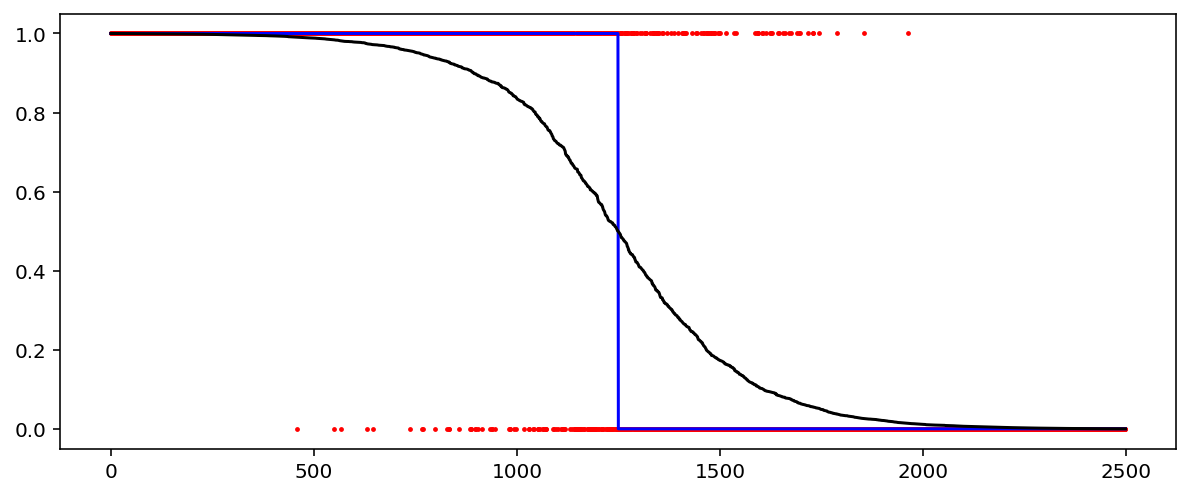

In [17]:
N = 2500
# N = 100
plt.figure(figsize=(10,4))
plt.scatter(range(N), Z.y_test.values[:N], c='r', s=2)
plt.plot(Z.y_pred.values[:N], c='b')
plt.plot(Z.prob.values[:N], c='k')

In [12]:
y_pred = model.predict_proba(X_test)[:,1] > 0.5 # 분류기의 동작
y_pred_high_recall = model.predict_proba(X_test)[:,1] > 0.2 # 분류기의 동작
y_pred_high_prec = model.predict_proba(X_test)[:,1] > 0.9 # 분류기의 동작

In [13]:
show_clf_result(y_test, y_pred) # 확률 0.5를 기준으로 나누는 모델의 동작과 동일한 것

[[1157  103]
 [  93 1147]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1260
           1       0.92      0.93      0.92      1240

    accuracy                           0.92      2500
   macro avg       0.92      0.92      0.92      2500
weighted avg       0.92      0.92      0.92      2500



In [14]:
show_clf_result(y_test, y_pred_high_recall) # 0.2 기준

[[ 993  267]
 [  40 1200]]
              precision    recall  f1-score   support

           0       0.96      0.79      0.87      1260
           1       0.82      0.97      0.89      1240

    accuracy                           0.88      2500
   macro avg       0.89      0.88      0.88      2500
weighted avg       0.89      0.88      0.88      2500



In [15]:
show_clf_result(y_test, y_pred_high_prec) # 0.9 기준

[[1244   16]
 [ 362  878]]
              precision    recall  f1-score   support

           0       0.77      0.99      0.87      1260
           1       0.98      0.71      0.82      1240

    accuracy                           0.85      2500
   macro avg       0.88      0.85      0.85      2500
weighted avg       0.88      0.85      0.85      2500



## Precision-Recall 커브

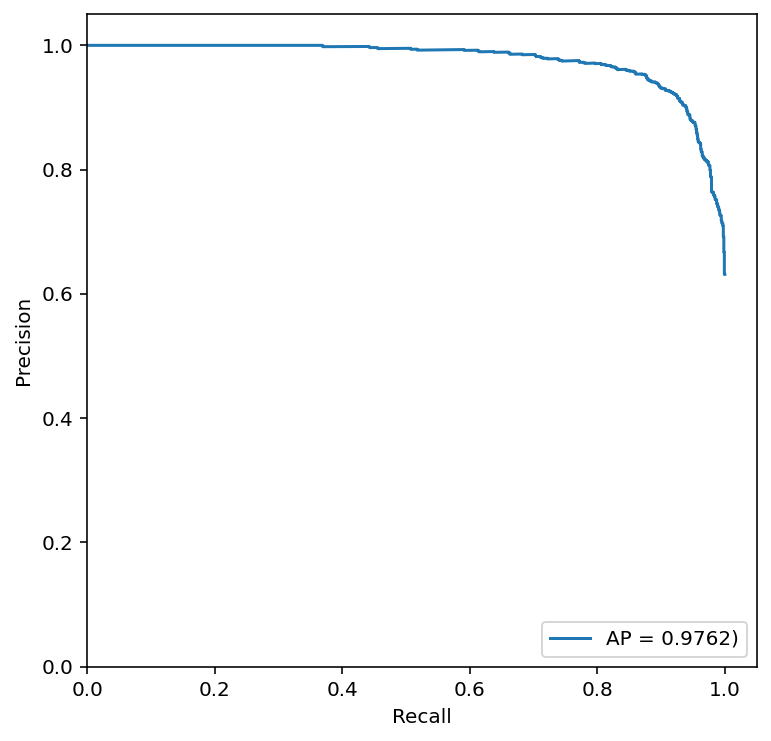

In [21]:
prec, rcl, thres = precision_recall_curve(Z.y_test, Z.prob)
ap = average_precision_score(Z.y_test, Z.prob)
plt.figure(figsize=(6,6))
plt.plot(rcl, prec, label='AP = %0.4f)' % ap)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")

###  precision_recall 테이블
- 정밀도, 리콜, 경계치 세가지 값을 리턴한다
- P-R 테이블 보기 (리콜이 1인 곳의 값부터 보여준다: 위 P-R 그래프의 우하단부터)
- 검증 데이터 2500개 중에 1922개의 샘플까지만 테이블에 들어있다
- 리콜이 1에 도달한 이후는 더 그릴 필요가 없음

In [22]:
# 정밀도, 리콜 테이블
PR = pd.DataFrame({"precision":prec[::-1], "recall":rcl[::-1]})
PR

,precision,recall
0,1.000000,0.000000
1,1.000000,0.000806
2,1.000000,0.001613
3,1.000000,0.002419
4,1.000000,0.003226
...,...,...
1960,0.632143,0.999194
1961,0.631820,0.999194
1962,0.631498,0.999194
1963,0.631177,0.999194


<AxesSubplot:>

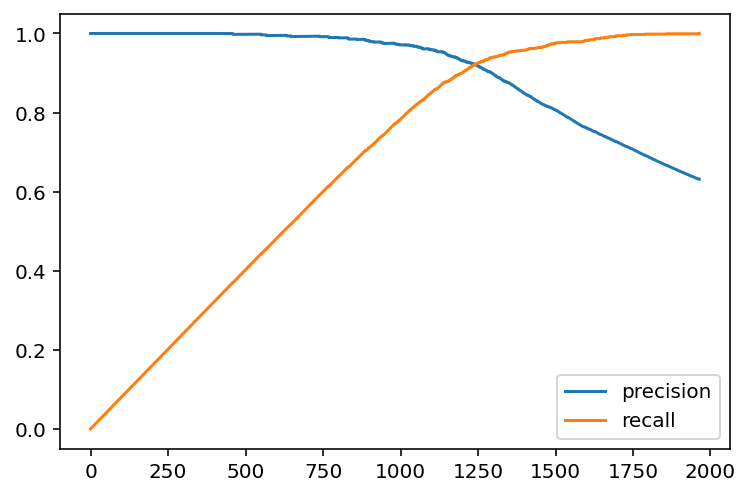

In [23]:
# P-R 테이블 내용을 그래프로 보기
PR.plot()

In [24]:
# PR 테이블의 첫 행은 삭제 (threshold와 행 갯수를 맞추기 위해서)
PR = PR[1:]
# treshold 컬럼 추가
PR["prob"] = thres[::-1]
PR

<ipython-input-24-c7d0f975db69>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PR["prob"] = thres[::-1]


,precision,recall,prob
1,1.000000,0.000806,0.999996
2,1.000000,0.001613,0.999991
3,1.000000,0.002419,0.999986
4,1.000000,0.003226,0.999985
5,1.000000,0.004032,0.999980
...,...,...,...
1960,0.632143,0.999194,0.014183
1961,0.631820,0.999194,0.014004
1962,0.631498,0.999194,0.013984
1963,0.631177,0.999194,0.013758


## 최소한의 리콜값 조건을 우선 선택하는 경우

In [29]:
PR[1710:1740]

,precision,recall,prob
1711,0.720631,0.994355,0.060358
1712,0.720210,0.994355,0.060298
1713,0.719790,0.994355,0.059718
1714,0.719370,0.994355,0.059369
1715,0.718950,0.994355,0.058942
1716,0.718531,0.994355,0.058937
1717,0.718113,0.994355,0.058763
1718,0.717695,0.994355,0.058636
1719,0.717859,0.995161,0.058593
1720,0.717442,0.995161,0.058571


In [30]:
# PR 테이블을 위에서부터 검색하여 처음으로 리콜값을 만족하는 지점을 argmax로 찾는다 (False 에서 처음으로 True가 되는 지점)
recall_min = 0.995 # 원하는 리콜 최소값
thres_cut = np.argmax(PR.recall >= recall_min)+1 # 조건을 만족하는 첫번째 위치
print(thres_cut)

1719


In [33]:
print("해당 지점 이전의 리콜", PR.recall[thres_cut-1])
print("해당 지점의 리콜", PR.recall[thres_cut])
print("해당 지점의 정밀도", PR.precision[thres_cut])
print("경계치 (prob):", PR.prob[thres_cut])

해당 지점 이전의 리콜 0.9943548387096774
해당 지점의 리콜 0.9951612903225806
해당 지점의 정밀도 0.7178592204770216
경계치 (prob): 0.058592865003999205


In [34]:
# 새로운 분류 경계치 thres_cut를 사용하여 분류를 다시 수행한다
new_y_pred = Z["prob"] >= PR.prob[thres_cut]
new_y_pred

8180     True
6811     True
7821     True
5883     True
5740     True
        ...  
900     False
82      False
1506    False
4331    False
2971    False
Name: prob, Length: 2500, dtype: bool

In [35]:
# 예측값이 True인 샘플만의 인덱스 얻기
new_index = new_y_pred.index[new_y_pred]

In [36]:
len(new_index)

1719

In [37]:
new_index[:10]

Int64Index([8180, 6811, 7821, 5883, 5740, 5214, 7324, 9002, 5655, 8442], dtype='int64')

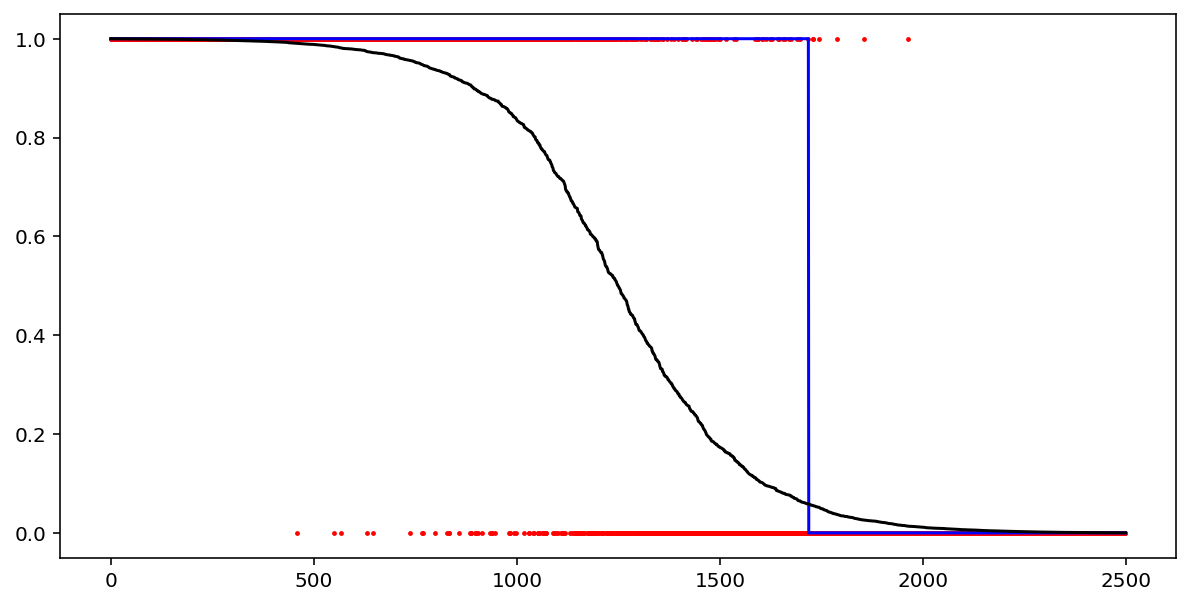

In [39]:
# 새로운 예측치 new_y_pred를 사용하여 예측값, 실제값, 분류 경계치 그리기
N = 2500
plt.figure(figsize=(10,5))
plt.scatter(range(N), Z.y_test.values[:N], c='r', s=2)
plt.plot(new_y_pred.values[:N], c='b')
plt.plot(Z.prob.values[:N], c='k')

In [41]:
show_clf_result(Z.y_test, new_y_pred)

[[ 775  485]
 [   6 1234]]
              precision    recall  f1-score   support

           0       0.99      0.62      0.76      1260
           1       0.72      1.00      0.83      1240

    accuracy                           0.80      2500
   macro avg       0.86      0.81      0.80      2500
weighted avg       0.86      0.80      0.80      2500



## 최소한의 정밀도를 우선 선택하는 경우

In [42]:
prec_min = 0.99
thres_cut = np.argmax(PR.precision < prec_min)

In [44]:
print("해당 지점의 정밀도", PR.precision[thres_cut])
print("해당 지점 다음 샘플의 정밀도", PR.precision[thres_cut+1])
print("해당 지점의 리콜", PR.recall[thres_cut])
print("경계치 threshold (이상):", PR.prob[thres_cut])
print(thres_cut)

해당 지점의 정밀도 0.9908972691807543
해당 지점 다음 샘플의 정밀도 0.9896103896103896
해당 지점의 리콜 0.614516129032258
경계치 threshold (이상): 0.9472837560809068
769


In [46]:
# 새로운 예측치
new_y_pred = Z["prob"] >= PR.prob[thres_cut]
# 1로 예측된 샘플수
new_y_pred.sum()

769

In [47]:
# 새로운 예측값의 인덱스 얻기
new_index = new_y_pred.index[new_y_pred].tolist()
len(new_index)

769

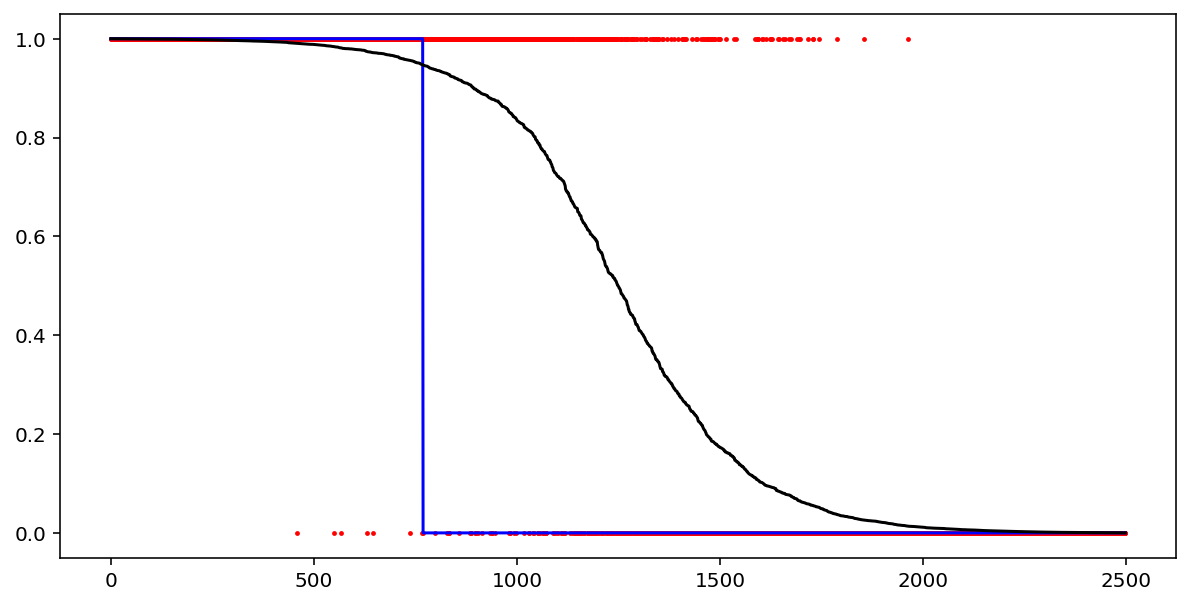

In [48]:
# 새로운 예측치 new_y_pred를 사용하여 예측값, 실제값, 분류 경계치 그리기
N = 2500
plt.figure(figsize=(10,5))
plt.scatter(range(N), Z.y_test.values[:N], c='r', s=2)
plt.plot(new_y_pred.values[:N], c='b')
plt.plot(Z.prob.values[:N], c='k')